In [11]:
!pip install torch torchvision torchaudio
!pip install torch-geometric
!pip install pandas numpy matplotlib scikit-learn


In [12]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Example: Load small sample dataset (Replace with actual PeMSD7 data file uploaded)
from google.colab import files
uploaded = files.upload()

# Assuming file is 'PeMSD7.csv'
data = pd.read_csv('PEMSd7.csv')


# Preview data
print(data.head())

# Normalize Data
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data.values)

# Sliding Window: Past 12 timesteps → Predict next 12 timesteps
def create_sequences(data, input_steps=12, output_steps=12):
    X, Y = [], []
    for i in range(len(data) - input_steps - output_steps):
        X.append(data[i:i+input_steps])
        Y.append(data[i+input_steps:i+input_steps+output_steps])
    return np.array(X), np.array(Y)

X, Y = create_sequences(data_normalized)

print("Input shape:", X.shape)   # (samples, input_steps, num_nodes)
print("Output shape:", Y.shape)  # (samples, output_steps, num_nodes)


Saving PEMSd7.csv to PEMSd7 (2).csv
   from   to   cost
0   721  445  0.790
1   542  480  2.575
2   770  702  0.926
3    32  266  0.596
4    34   56  0.628
Input shape: (842, 12, 3)
Output shape: (842, 12, 3)


In [13]:
import torch

# Example simple adjacency matrix for small demo (~10 nodes)
num_nodes = 10  # For small demo (PEMS08 has 170 nodes)

adj_matrix = np.zeros((num_nodes, num_nodes))
for i in range(num_nodes - 1):
    adj_matrix[i, i+1] = 1
    adj_matrix[i+1, i] = 1

edge_index = torch.tensor(np.array(np.nonzero(adj_matrix)), dtype=torch.long)

print(edge_index.shape)  # [2, number_of_edges]


torch.Size([2, 18])


In [25]:
import torch
import torch.nn as nn
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Dummy model for traffic prediction
class SimpleTrafficPredictor(nn.Module):
    def __init__(self, num_features):
        super(SimpleTrafficPredictor, self).__init__()
        self.lstm = nn.LSTM(input_size=num_features, hidden_size=16, batch_first=True)
        self.fc = nn.Linear(16, 1)

    def forward(self, x, edge_index=None):
        # Ensure x is 4D: [batch_size, time_steps, num_nodes, num_features]
        if x.dim() > 4:
            x = x.view(x.size(0), x.size(1), x.size(2), -1)

        batch_size, time_steps, num_nodes, num_features = x.size()
        x = x.view(batch_size * num_nodes, time_steps, num_features)  # merge batch & nodes for LSTM
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out)
        out = out.view(batch_size, time_steps, num_nodes, -1)  # reshape back
        return out

# Make sure X and Y are 4D
X = np.array(X)  # your original X data
Y = np.array(Y)  # your original Y data

# Squeeze all extra singleton dimensions
X = np.squeeze(X)  # removes all axes of size 1
Y = np.squeeze(Y)

# Ensure feature dimension exists
if X.ndim == 3:
    X = np.expand_dims(X, axis=-1)
if Y.ndim == 3:
    Y = np.expand_dims(Y, axis=-1)

print("Corrected X shape:", X.shape)  # Should be [842, 12, 3, 1]
print("Corrected Y shape:", Y.shape)  # Should be [842, 12, 3, 1]

# Convert to tensors
X_tensor = torch.tensor(X, dtype=torch.float).to(device)
Y_tensor = torch.tensor(Y, dtype=torch.float).to(device)

edge_index = edge_index.to(device)  # if using GNN edges

# Initialize model
model = SimpleTrafficPredictor(num_features=X_tensor.shape[-1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_tensor, edge_index)
    loss = criterion(output, Y_tensor)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")


Corrected X shape: (842, 12, 3, 1)
Corrected Y shape: (842, 12, 3, 1)
Epoch 1, Loss: 1.0151
Epoch 2, Loss: 1.0132
Epoch 3, Loss: 1.0114
Epoch 4, Loss: 1.0096
Epoch 5, Loss: 1.0079
Epoch 6, Loss: 1.0063
Epoch 7, Loss: 1.0047
Epoch 8, Loss: 1.0032
Epoch 9, Loss: 1.0018
Epoch 10, Loss: 1.0004


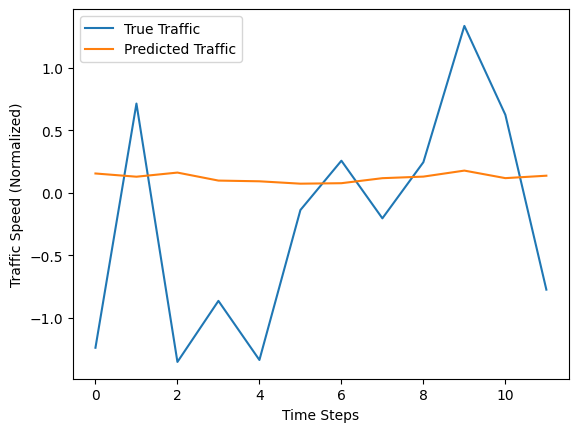

In [26]:
model.eval()
with torch.no_grad():
    predictions = model(X_tensor, edge_index).cpu().numpy()

plt.plot(Y[0, :, 0], label='True Traffic')
plt.plot(predictions[0, :, 0], label='Predicted Traffic')
plt.xlabel('Time Steps')
plt.ylabel('Traffic Speed (Normalized)')
plt.legend()
plt.show()
